In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:

torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
resnet.fc = torch.nn.Identity()
resnet.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(video_path, max_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = transform(frame)
        frames.append(frame)

    cap.release()

    num_frames = len(frames)

    if num_frames == 0:
        return torch.zeros((max_frames, 2048))

    elif num_frames < max_frames:
        while len(frames) < max_frames:
            frames.append(frames[-1])

    else:
        indices = np.linspace(0, num_frames - 1, max_frames, dtype=int)
        frames = [frames[i] for i in indices]

    frames = torch.stack(frames).to(device, non_blocking=True)


    with torch.no_grad():
        features = resnet(frames)

    return features.cpu().numpy()


brawl_videos = glob("/content/drive/MyDrive/Dataset/Dataset/Brawl/*.mp4")
non_brawl_videos = glob("/content/drive/MyDrive/Dataset/Dataset/Peace/*.mp4")

features = []
labels = []


print("\nExtracting features for BRAWL videos...")
for video in tqdm(brawl_videos):
    features.append(extract_features(video))
    labels.append(1)


features = np.array(features)
labels = np.array(labels)

np.save("features.npy", features)
np.save("labels.npy", labels)

print("\n Feature extraction complete! Features saved to disk.")


Using device: cuda


In [ ]:
features = []
labels = []

print("\nExtracting features for PEACE videos...")
for video in tqdm(non_brawl_videos):
    features.append(extract_features(video))
    labels.append(0)

features = np.array(features)
labels = np.array(labels)

np.save("features1.npy", features)
np.save("labels1.npy", labels)
print("\n Feature extraction complete! Features saved to disk.")



Extracting features for PEACE videos...


100%|██████████| 800/800 [11:09<00:00,  1.19it/s]



 Feature extraction complete! Features saved to disk.


In [ ]:
features1 = np.load("features.npy")
features2 = np.load("features1.npy")

combined_features = np.concatenate((features1, features2), axis=0)

labels1 = np.load("labels.npy")
labels2 = np.load("labels1.npy")

combined_labels = np.concatenate((labels1, labels2), axis=0)

np.save("labels_combined.npy", combined_labels)

np.save("features_combined.npy", combined_features)

print("Features successfully combined and saved as 'features_combined.npy'!")


Features successfully combined and saved as 'features_combined.npy'!


In [ ]:
test_videos = glob("/content/drive/MyDrive/Test/*.mp4")

test_features = []

print("\nExtracting features for TEST videos...")
for video in tqdm(test_videos):
    feature = extract_features(video)
    test_features.append(feature)

test_features = np.array(test_features)

np.save("test_features.npy", test_features)

print("\n✅ Feature extraction complete! Test features saved as 'test_features.npy'.")


Extracting features for TEST videos...


100%|██████████| 400/400 [04:26<00:00,  1.50it/s]



✅ Feature extraction complete! Test features saved as 'test_features.npy'.


Epoch 1:
Train Loss: 0.2200, Val Loss: 0.1874
Accuracy: 0.9062, Precision: 0.8382, Recall: 0.9864, F1 Score: 0.9062
New best accuracy: 0.9062. Model saved!
Epoch 2:
Train Loss: 0.1000, Val Loss: 0.2360
Accuracy: 0.9000, Precision: 0.8249, Recall: 0.9932, F1 Score: 0.9012
Epoch 3:
Train Loss: 0.0647, Val Loss: 0.0713
Accuracy: 0.9812, Precision: 0.9930, Recall: 0.9660, F1 Score: 0.9793
New best accuracy: 0.9812. Model saved!
Epoch 4:
Train Loss: 0.0456, Val Loss: 0.0483
Accuracy: 0.9844, Precision: 0.9931, Recall: 0.9728, F1 Score: 0.9828
New best accuracy: 0.9844. Model saved!
Epoch 5:
Train Loss: 0.0356, Val Loss: 0.0851
Accuracy: 0.9750, Precision: 0.9542, Recall: 0.9932, F1 Score: 0.9733
Epoch 6:
Train Loss: 0.0434, Val Loss: 0.0460
Accuracy: 0.9844, Precision: 0.9931, Recall: 0.9728, F1 Score: 0.9828
Epoch 7:
Train Loss: 0.0197, Val Loss: 0.0367
Accuracy: 0.9938, Precision: 0.9932, Recall: 0.9932, F1 Score: 0.9932
New best accuracy: 0.9938. Model saved!
Epoch 8:
Train Loss: 0.0057,

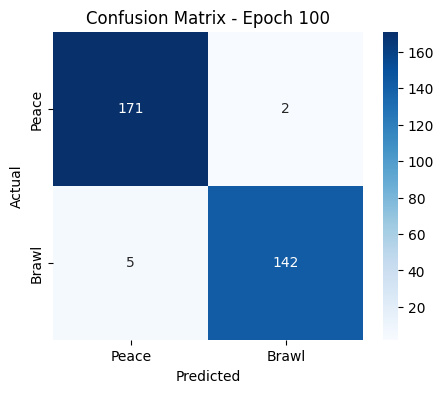

Best model saved with accuracy: 0.9938


In [5]:

features = np.load("/content/features_combined.npy")
labels = np.load("/content/labels_combined.npy")

features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

class BrawlFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = BrawlFeatureDataset(features, labels)
train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=2048, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        x = self.fc(hidden[-1])
        return torch.sigmoid(x)

def plot_confusion_matrix(y_true, y_pred, epoch):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Peace", "Brawl"], yticklabels=["Peace", "Brawl"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.show()


def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_acc = 0.0
    best_model_wts = None

    for epoch in range(100):
        model.train()
        train_loss = 0.0
        for videos, labels in train_loader:
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(device), labels.to(device)
                outputs = model(videos).squeeze()
                preds = (outputs > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                loss = criterion(outputs, labels)
                val_loss += loss.item()


        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, zero_division=0)
        rec = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")


        if acc > best_acc:
            best_acc = acc
            best_model_wts = model.state_dict()
            print(f"New best accuracy: {best_acc:.4f}. Model saved!")


        if epoch == 99:
            plot_confusion_matrix(all_labels, all_preds, epoch)


    if best_model_wts:
        model.load_state_dict(best_model_wts)
        torch.save(model, "best_lstm_model.pth")
        print("Best model saved with accuracy: {:.4f}".format(best_acc))
train_model()

In [1]:
test_videos = glob("/content/drive/MyDrive/Test/*.mp4")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_features = np.load("test_features.npy")

test_features = torch.tensor(test_features, dtype=torch.float32).to(device)

model = torch.load("best_lstm_model.pth", weights_only=False)

model.eval()

with torch.no_grad():
    outputs = model(test_features).squeeze()
    predicted_labels = (outputs > 0.5).float().cpu().numpy()


video_ids = []

for video_name, pred in zip(test_videos, predicted_labels):
    video_id = os.path.basename(video_name).split('.')[0]
    video_ids.append(video_id)

df = pd.DataFrame({
    'videoID': video_ids,
    'prediction': predicted_labels.astype(int)
})

df.to_csv("test_predictions.csv", index=False)

print("\nPredictions saved to 'test_predictions.csv'")


Predictions saved to 'test_predictions.csv'
